In [1]:
import os
import cv2
import glob
import math
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
sns.set()

from xml.dom import minidom
from svg.path import parse_path
from svg.path.path import Line

In [2]:
def svg2array(svg_path, max_size, pts_per_seg=1):
    """ Função que recebe o caminho para um arquivo svg com um desenho produzido a partir de uma única linha e retorna uma 
    lista com as coordenadas dos pontos pertencentes à linha que forma o desenho.
    """
    
    # Extrai path_strings do arquivo svg
    doc = minidom.parse(svg_path)
    path_strings = [path.getAttribute('d') for path in doc.getElementsByTagName('path')]
    doc.unlink()
    
    # Usa a biblioteca svg.path para extrair as coordenadas dos pontos do desenho
    path = parse_path(path_strings[0])
    points = np.zeros( (pts_per_seg*len(path)+1, 2) )
    for i, e in enumerate(path):
        # Se pts_per_seg >1 interpola os valores para produzir mais pontos
        for j in range(pts_per_seg):
            x = e.start.real + j * (e.start.real - e.end.real) / pts_per_seg
            y = e.start.imag + j * (e.start.imag - e.end.imag) / pts_per_seg
            points[pts_per_seg*i+j] = np.array([x, y])
        if i == len(path)-1:
            points[-1] = np.array([e.end.real, e.end.imag])
    
    # Realiza uma translação para centralizar o desenho na imagem
    offset_x = (np.min(points[:,0]) + np.max(points[:,0])) // 2
    offset_y = (np.min(points[:,1]) + np.max(points[:,1])) // 2
    offset = np.reshape( np.array([offset_x, offset_y]), (1, 2))
    points -= offset
    
    # Reescala o desenho
    points = points * ( (3*max_size // 8) / np.max(points) ) + max_size // 2
    
    # Arredonda para que os pontos assumam valores inteiros
    return np.array( np.around(points), dtype="uint16" )

def calc_coefs_fourier(points, n_coefs):
    
    # Transforma os pontos em números complexos e associa cada ponto a um valor de t
    n_pts = points.shape[0]
    delta_t = 1 / n_pts
    valores_t = np.linspace(0, 1, num = n_pts) 
    func_de_t = np.array([pt[0]+pt[1]*1j for pt in points])
    
    # Caso o número de coeficientes fornecido seja par, acrescenta 1
    n_coefs = n_coefs+1 if n_coefs % 2 == 0 else n_coefs
    max_coef = (n_coefs - 1) // 2
    
    # varia n de -max_coef a +max_coef e calcula os coeficientes da série de fourier
    coefs = []
    for i, n in enumerate(range(-max_coef, max_coef+1)):
        if i % int((1/50)*n_coefs) == 0:
            progress = (i // int((1/50)*n_coefs))
            print("["+"-"*progress+"."*(50-progress)+"] Coefficient {} of {}".format(i, n_coefs), end="\r")  
            
        coef = np.sum( [func_de_t[idx] * np.exp(-2 * math.pi * 1j * n * t) * delta_t for idx, t in enumerate(valores_t)] )
        coefs.append(coef)
    
    return np.array(coefs)

def sintetiza_funcao(coefs, n_pontos):
    
    # Determina os limites dos coeficientes e os valores de t para amostras igualmente espaçadas no intervalo entre 0 e 1
    max_coef = (coefs.shape[0] - 1) // 2
    valores_t = np.linspace(0, 1, num = n_pontos) 
    
    # Calcula os valores de f(t) a partir da série de fourier
    f_de_t = []
    for i, t in enumerate(valores_t):
        if i % int((1/50)*n_pontos) == 0:
            progress = (i // int((1/50)*n_pontos))
            print("["+"-"*progress+"."*(50-progress)+"] Point {} of {}".format(i, n_pontos), end="\r")  

        f = np.sum( [coef * np.exp( 2*math.pi*1j*n*t ) for (coef, n) in zip(coefs, range(-max_coef, max_coef+1))] )
        f_de_t.append(f)
        
    # Converte os valores complexos para vetores
    points = np.zeros( (n_pontos, 2) )
    for i, f in enumerate(f_de_t):
        points[i] = np.array([f.real, f.imag])
    
    # Arredonda para que os pontos assumam valores inteiros
    return np.array( np.around(points), dtype="uint16" )

Image 1: 1911 points
	Y values between 190 and 845
	X values between 133 and 896
	P0 = [841 151]
	P1911 = [841 151]


Reconstrução 1: 500 points------------------------.] Point 490 of 500of 251
	Y values between 190 and 951
	X values between 132 and 895
	P0 = [951 168]
	P500 = [951 168]



Image 2: 8506 points
	Y values between 137 and 896
	X values between 169 and 856
	P0 = [710 845]
	P8506 = [710 845]


Reconstrução 2: 500 points------------------------.] Point 490 of 500of 251
	Y values between 142 and 890
	X values between 171 and 862
	P0 = [728 862]
	P500 = [728 862]



Image 3: 6736 points
	Y values between 142 and 896
	X values between 139 and 894
	P0 = [527 144]
	P6736 = [527 144]


Reconstrução 3: 500 points------------------------.] Point 490 of 500of 251
	Y values between 147 and 894
	X values between 142 and 890
	P0 = [552 150]
	P500 = [552 150]



Image 4: 16286 points
	Y values between 130 and 896
	X values between 201 and 827
	P0 = [467 757]
	P16286 = [467 757]


Reconst

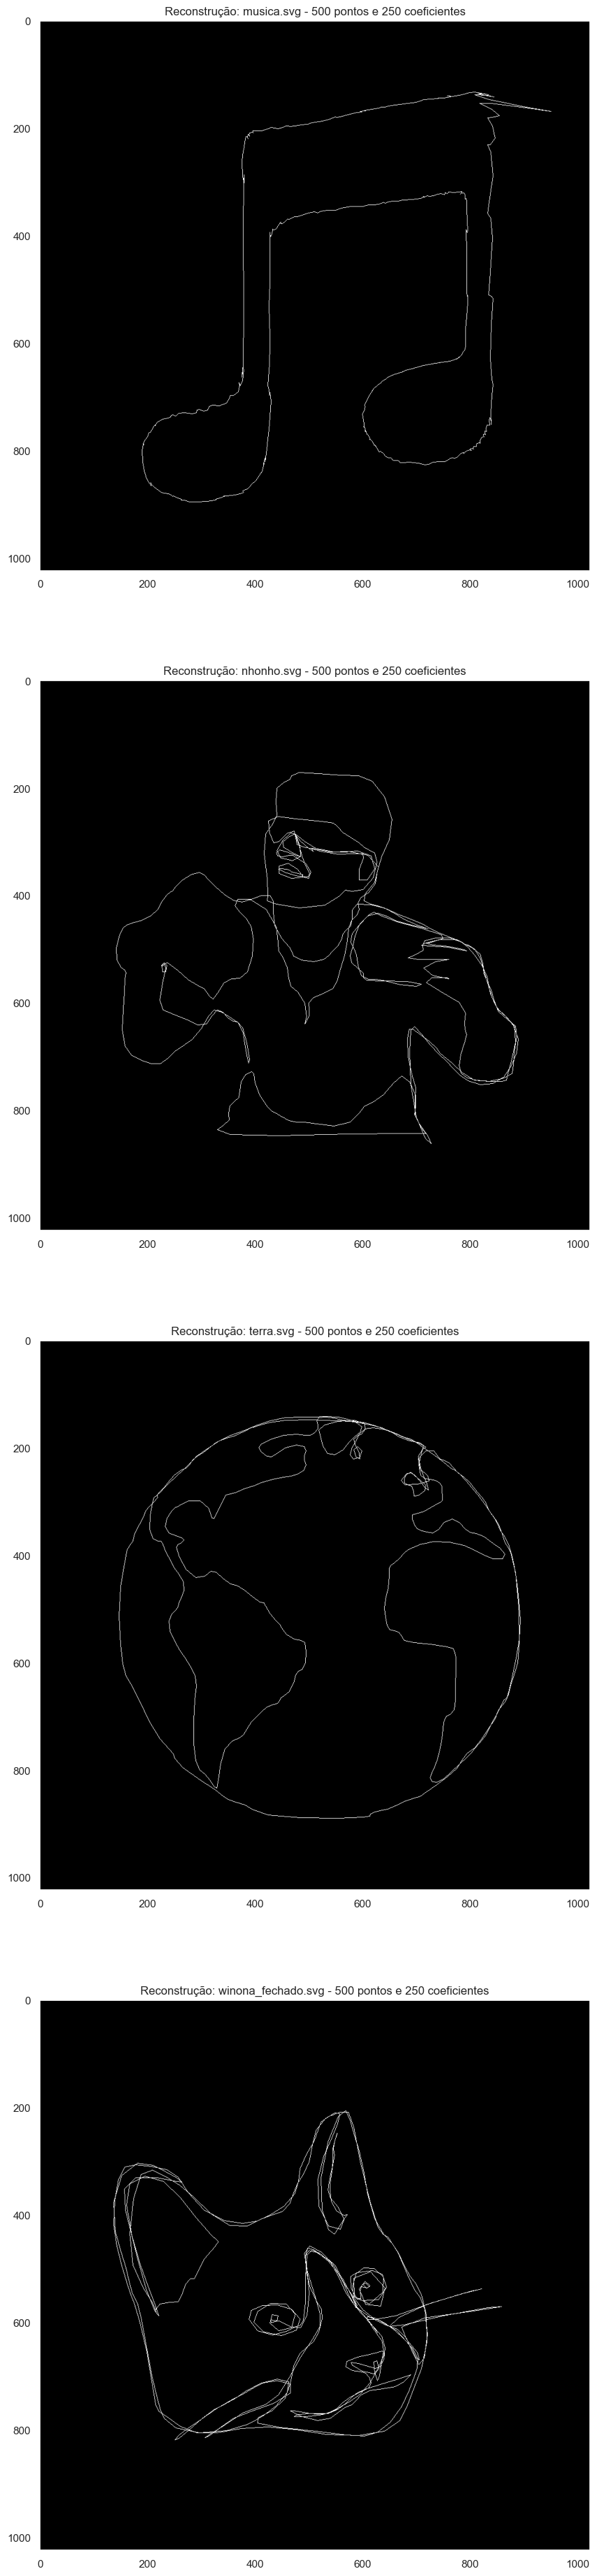

In [3]:
n_coefs = 250
f_n_pts = 500
img_size = 1024
pts_per_seg = 5
line_thickness = 1
draw_paths = glob.glob(os.path.join(".", "drawings", "*.svg"))

coefs = []
filenames = []
n_plots = len(draw_paths)
fig, axs = plt.subplots(n_plots, 1, figsize=(16, 12 * n_plots), dpi=100)

for idx, (svg_path, ax) in enumerate(zip(draw_paths, axs.flatten())):
    
    points = svg2array(svg_path, img_size, pts_per_seg=pts_per_seg)
    n_points = points.shape[0]
    
    print("Image {}: {} points".format(idx+1, n_points))
    print("\tY values between {} and {}".format(np.min(points[:,0]), np.max(points[:,0])))
    print("\tX values between {} and {}".format(np.min(points[:,1]), np.max(points[:,1])))
    print("\tP0 = {}".format(points[0]))
    print("\tP{} = {}".format(n_points, points[-1]))
    print("\n")
    
    # Calcula coeficientes da série de fourier
    f_coefs = calc_coefs_fourier(points, n_coefs)
    coefs.append(f_coefs)
    filenames.append(os.path.basename(svg_path))
    
    # Sintetiza a função a partir da série de fourier
    new_points = sintetiza_funcao(f_coefs, f_n_pts)
    n_points = new_points.shape[0]
    
    print("Reconstrução {}: {} points".format(idx+1, n_points))
    print("\tY values between {} and {}".format(np.min(new_points[:,0]), np.max(new_points[:,0])))
    print("\tX values between {} and {}".format(np.min(new_points[:,1]), np.max(new_points[:,1])))
    print("\tP0 = {}".format(new_points[0]))
    print("\tP{} = {}".format(n_points, new_points[-1]))
    print("\n\n")
    
    # Desenha a figura
    canvas = np.zeros((img_size,img_size), dtype="float32")
    for i in range(1, int(1*n_points)):
        cv2.line(canvas, (new_points[i-1, 0], new_points[i-1, 1]), (new_points[i, 0], new_points[i, 1]), 1, thickness=line_thickness)
        
    ax.imshow(canvas, cmap="gray", vmin=0, vmax=1)
    ax.set_title("Reconstrução: {} - {} pontos e {} coeficientes".format(os.path.basename(svg_path), n_points, n_coefs))
    ax.grid(False)

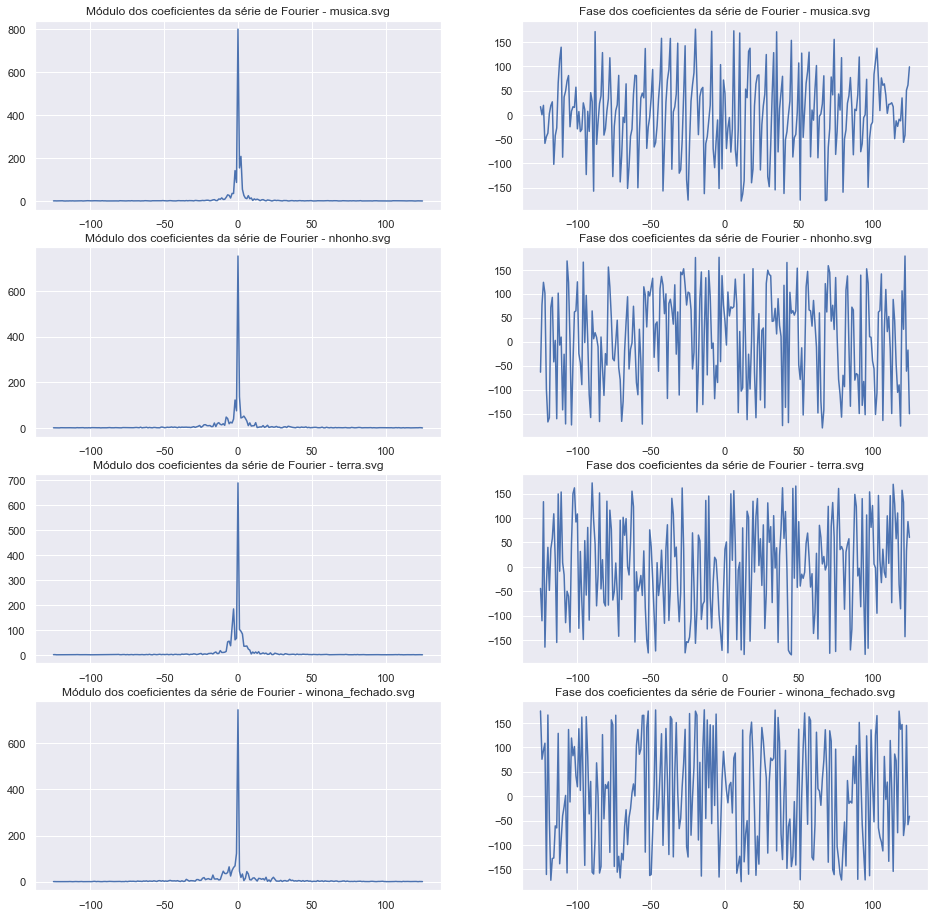

In [4]:
n_plots = len(coefs)
fig, axs = plt.subplots(n_plots, 2, figsize=(16, 4 * n_plots))

for i, (f_coefs, fname) in enumerate(zip(coefs, filenames)):
    
    ax = axs.flatten()[2*i]
    max_coefs = (len(f_coefs)-1)//2
    f_abs = np.absolute(f_coefs)
    coef_vals = [n for n in range(-max_coefs, max_coefs+1)]
    ax.plot(coef_vals, f_abs)
    ax.set_title("Módulo dos coeficientes da série de Fourier - {}".format(fname))
    
    ax = axs.flatten()[2*i+1]
    f_phase = 180*np.angle(f_coefs)/math.pi
    ax.plot(coef_vals, f_phase)
    ax.set_title("Fase dos coeficientes da série de Fourier - {}".format(fname))